In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import integrate as sg
from scipy import interpolate as si

plt.style.use("../paper.mplstyle")

In [2]:
index_col = "frequency_cm"
df_pdos = pd.read_csv("outfile.2pdos.csv", index_col=index_col)
df_cdos = pd.read_csv("outfile.phonon_dos_convolutions.csv", index_col=index_col)

s_pdos = df_pdos["2PDOS"]
s_cdos = df_cdos.dos_weighted_convoluted
s_wdos = df_pdos["2wDOS"]

df_pdos.columns

Index(['frequency', '2PDOS', '2PDOS_1', '2PDOS_2', '2wDOS', '2wDOS_1',
       '2wDOS_2', 'DOS_convolution', 'DOS_convolution_1', 'DOS_convolution_2'],
      dtype='object')

In [3]:
# interpolate to same grid
# fit out the intensity


def interpolate(
    s: pd.Series,
    x: np.ndarray,
    kind: str = "cubic",
    fill_value: float = 0.0,
    x_scale: float = 1.0,
):
    _s = s.dropna()
    _x = np.asarray(_s.index) * x_scale
    _y = np.asarray(_s)

    f = si.interp1d(_x, _y, kind=kind, fill_value=fill_value, bounds_error=False)

    return pd.Series(f(x), index=x, name=s.name)


x = np.linspace(-800, 800, 10000)

x_scale = 1.0  # 1.05
s_cdos_interpolated = interpolate(s_cdos, x, x_scale=x_scale)
s_pdos_interpolated = interpolate(s_pdos, x, x_scale=x_scale)
s_wdos_interpolated = interpolate(s_wdos, x, x_scale=x_scale)

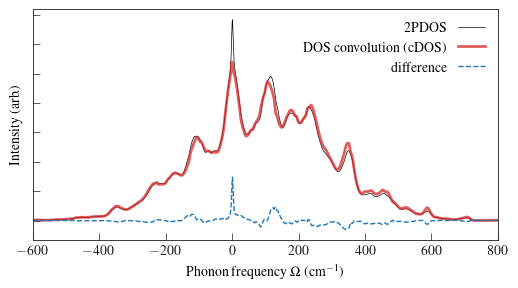

In [4]:
# 2PDOS vs. cDOS


def normalize(s):
    return s / sg.trapezoid(s, x=s.index)


def plot_pdos_cdos(s_pdos, s_cdos, y_shift=0, figsize=(6, 3)):
    fig, ax = plt.subplots(figsize=figsize)

    _s0 = normalize(s_pdos)
    _s1 = normalize(s_cdos) + y_shift
    _s0.plot(ax=ax, color="k", lw=0.5)  # , lw=3, ls='--')
    _s1.plot(ax=ax, color="C3", lw=2, ls="-", alpha=0.75)

    (_s0 - _s1).plot(ax=ax, color="C0", lw=1, ls="--")

    ax.set_yticklabels([])
    ax.set_xlim(-600, 800)

    ax.set_xlabel(r"Phonon frequency $\Omega$ (cm$^{-1}$)")
    ax.set_ylabel("Intensity (arb.)")

    ax.legend(
        ["2PDOS", "DOS convolution (cDOS)", "difference"],
        loc=1,
        markerfirst=False,
        frameon=False,
    )

    return fig, ax


fig, ax = plot_pdos_cdos(s_pdos_interpolated, s_cdos_interpolated)

file="plot_bzs_pdos_vs_cdos.pdf"

fig.savefig(file)
fig.savefig(Path(file).stem + ".png")